In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
class BasicBoat:
    def __init__(self, w = [1,1], start = [0, 0], target = [10, 10]):
        self.start = start[:]
        self.target = target[:]
        self.X = np.array([[start[0]],
                           [start[1]],
                           [w[0]],
                           [w[1]]])
        self.theta = np.radians(0)
        self.A = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        self.B = np.array([[w[1]-w[0]],
                           [-w[1]-w[0]],
                           [0],
                           [0]])
        self.res = self.X[:]

    def run(self, action_list = list(range(100)), t_step = 1):
        A = self.A + np.array([[0, 0, t_step, 0],
                               [0, 0, 0, t_step],
                               [0, 0, 0, 0],
                               [0, 0, 0, 0]])
        for theta in action_list:
            self.X = A.dot(self.X) + self.B*theta
            self.res = np.column_stack((self.res, self.X))

    def plot_res(self):
        plt.plot(self.res[0,:], self.res[1,:], '.',
                 self.start[0], self.start[1], '*',
                 self.target[0], self.target[1], '*')
        plt.title('Position of boat')
        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.legend(['Boat', 'Start', 'Target'])

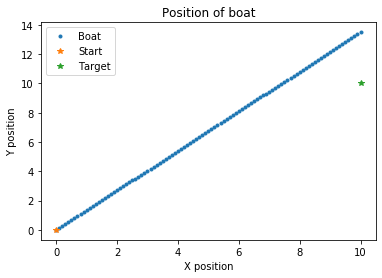

In [6]:
b1 = BasicBoat()
b1.run(action_list = np.ones(100)*np.radians(-1), t_step = 0.1)
b1.plot_res()

In [187]:
class LQRBoat:
    def __init__(self, w = [2,1], dt = 0.1, start = [0, 0], target = [10, 10]):
        self.start = start[:]
        self.target = target[:]
        w = w/np.linalg.norm(w)

        # System description
        self.X = np.array([[start[0] - target[0]],
                           [start[1] - target[1]]])
        self.Sigma = np.identity(4)*0.999
        self.A = np.array([[1, 0],
                           [0, 1]])
        self.B = np.array([[w[0], -w[1]],
                           [w[1], w[0]]]) * dt

        # LQR inits
        self.Q = np.array([[-100, 0],
                           [ 0,-10]]) # x, y
        self.R = np.array([[-1, 0],
                           [ 0,-50]]) # Alpha, Alpha*Theta
        self.P = {0: np.zeros((2,2))}
        self.M = {0: np.zeros((2,1))}
        self.res = self.X[:]

    def run(self, n_steps = 10, p_steps = 10):
        P, M = self._optimal_pi(n=p_steps)
        for i in list(range(n_steps+5)):
            u = -M@self.X
            self.X = self.A@self.X + self.B@u
            self.res = np.column_stack((self.res, self.X))

    def _optimal_pi(self, n):
        if n not in self.P:
            P_back, M_back = self._optimal_pi(n-1)
            p1 = self.A.T@P_back@self.A
            p2 = self.A.T@P_back@self.B
            self.P[n] = p1-p2@M_back+self.Q
            self.M[n] = np.linalg.inv(self.R + self.B.T@self.P[n]@self.B)@(self.B.T@self.P[n]@self.A)
        return self.P[n], self.M[n]

    def plot_res(self):
        fig = plt.figure(figsize=(11,11))
        plt.plot(self.res[0,:], self.res[1,:], '.',
                 self.start[0]-self.target[0], self.start[1]-self.target[1], '*',
                 self.start[0], self.start[1], 'o')
        plt.title('Position of boat')
        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.legend(['Boat', 'Start', 'Target'])

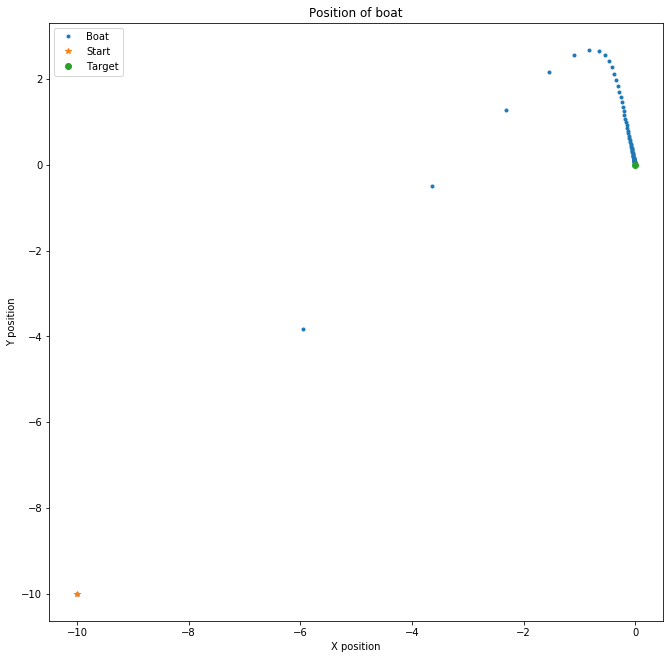

In [188]:
lqr = LQRBoat(w=[0.5, np.sqrt(1-0.5**2)])
lqr.run(100, 100)
lqr.plot_res()

In [183]:
lqr.M[100]

array([[ 1.35078106,  2.33962142],
       [-1.14120038,  0.65887234]])

In [184]:
np.linalg.eig(lqr.A-lqr.B@lqr.M[100])

(array([0.86822553, 0.72984379]), array([[ 0.8660254,  0.5      ],
        [-0.5      ,  0.8660254]]))

In [122]:
class GPSBoat:
    def __init__(self, start = [0,0], w_vel = [1,1]):
        self.X = np.array(start).reshape((2,1))
        self.W = np.array(w_vel).reshape((2,1))
        self.W = self.W/np.linalg.norm(self.W)
        
        self.K = 10
        self.sigma_x = 0.001
        self.sigma_y = 0.1
    
    def step(self, theta, ts = 0.5):
        tlist = np.linspace(0, ts, 1001)
        fpos = odeint(self._diffs, np.reshape(self.X, (2,)), tlist, args=(theta, self.K))
        self.X = fpos[-1,:].reshape((2,1))
        return self.X+self.sigma_y*np.random.randn(2,1)

    def _diffs(self, y, t, theta, k):
        Rw = self._R(theta)@self.W
        return np.reshape(k*self.W.T@Rw*Rw+self.sigma_x*np.random.randn(2,1), (2,))

    def _R(self, theta):
        return np.array([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta),  np.cos(theta)]])

In [126]:
gg = GPSBoat()
gg.step(theta=np.radians(0), ts = 1)

array([[7.1406982 ],
       [7.02084444]])